In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import logging

## Logging setup
# # logging.basicConfig(level=logging.DEBUG)

def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)


def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if(0.1*i == 0.5):
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21,1)

def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def show_result_plt(x, y, pred_y):
    plt.subplot(2, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
        
    plt.subplot(2, 2, 2)
    plt.text(0, 0, f'Accuracy: {sum(pred_y == y) / y.size}', fontsize=16, 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

class Conv_Layer:
    def __init__(self, kernel_size, padding, stride, activation_function="sigmoid"):
        self.kernel = np.random.randn(kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.input = None
        self.output = None
        self.activation_function = activation_function

    def conv2d(self, input_data, kernel, stride):
        x_row, x_col = input_data.shape
        kernel_row, kernel_col = kernel.shape
        ret_row = (x_row - kernel_row + 2 * self.padding) // stride + 1
        ret_col = (x_col - kernel_col + 2 * self.padding) // stride + 1
        ret = np.zeros((ret_row, ret_col))

        if self.padding != 0:
            input_data = np.pad(input_data, ((self.padding, self.padding), (self.padding, self.padding)), 'constant', constant_values=0)

        for i in range(ret_row):
            for j in range(ret_col):
                ret[i, j] = np.sum(input_data[i*stride:i*stride+kernel_row, j*stride:j*stride+kernel_col] * kernel)
        return ret

    def forward(self, input_data):
        self.input = input_data
        self.output = self.conv2d(self.input, self.kernel, self.stride)
        # logging.debug(f"Conv_Layer forward output shape: {self.output.shape}")
        if self.activation_function == "sigmoid":
            self.output = sigmoid(self.output)
        elif self.activation_function == "ReLU":
            self.output = ReLU(self.output)
        elif self.activation_function == "linear":
            pass
        else:
            raise ValueError("Unsupported activation function")
        return self.output

    def backward(self, loss_derivative, learning_rate,optimize, decay_rate):
        if self.activation_function == "sigmoid":
            loss_derivative *= sigmoid_derivative(self.output)
        elif self.activation_function == "ReLU":
            loss_derivative *= ReLU_derivative(self.output)
        elif self.activation_function == "linear":
            pass
        else:
            raise ValueError("Unsupported activation function")
        kernel_gradient = self.conv2d(self.input, loss_derivative, self.stride)
        self.kernel -= learning_rate * kernel_gradient
        return loss_derivative

class FlattenLayer:
    def forward(self, input_data):
        self.input_shape = input_data.shape
        self.output = input_data.flatten().reshape(1, -1)
        # logging.debug(f"FlattenLayer output shape: {self.output.shape}")
        return self.output

    def backward(self, loss_derivative, learning_rate, optimize, decay_rate):
        return loss_derivative.reshape(self.input_shape)

class Layer:
    def __init__(self, input_size, output_size, activation_function="sigmoid"):
        self.W = np.random.randn(input_size, output_size)
        self.b = np.zeros((1, output_size))
        self.z = None
        self.v_w = 0
        self.v_b = 0
        self.input = None
        self.output = None
        self.activation_function = activation_function

    def forward(self, input_data):
        self.input = input_data
        self.z = np.dot(input_data, self.W) + self.b
        if self.activation_function == "sigmoid":
            self.output = sigmoid(self.z)
        elif self.activation_function == "ReLU":
            self.output = ReLU(self.z)
        elif self.activation_function == "linear":
            self.output = self.z
        else:
            raise ValueError("Unsupported activation function")
        # logging.debug(f"Layer forward output shape: {self.output.shape}")
        return self.output

    def backward(self, loss_derivative, learning_rate, optimize, decay_rate):
        if self.activation_function == "sigmoid":
            activation_derivative = sigmoid_derivative(self.output)
        elif self.activation_function == "ReLU":
            activation_derivative = ReLU_derivative(self.output)
        elif self.activation_function == "linear":
            activation_derivative = 1
        else:
            raise ValueError("Unsupported activation function")
        # logging.debug(f"Layer backward loss_derivative shape: {loss_derivative.shape}")
        delta = loss_derivative * activation_derivative
        dw = np.dot(self.input.T, delta)
        db = np.sum(delta, axis=0, keepdims=True)
        if optimize == "SGD":
            self.W -= learning_rate * dw
            self.b -= learning_rate * db
        elif optimize == "momentum":
            self.v_w = decay_rate * self.v_w + learning_rate * dw
            self.W -= self.v_w
            self.v_b = decay_rate * self.v_b + learning_rate * db
            self.b -= self.v_b
        else:
            raise ValueError("Unsupported optimize function")
        return np.dot(delta, self.W.T)
    
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = []
        self.predictions = None

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, loss_derivative, learning_rate, optimize, decay_rate):
        for layer in reversed(self.layers):
            loss_derivative = layer.backward(loss_derivative, learning_rate, optimize, decay_rate)

    def mse_loss(self, y, y_hat):
        return np.mean((y - y_hat) ** 2)

    def mse_loss_derivative(self, y, y_hat):
        return 2 * (y_hat - y) / y.size

    def train(self, X, y, epochs, learning_rate, optimize="SGD", decay_rate=0.9):
        for epoch in range(epochs):
            loss_temp = []
            for i in range(X.shape[0]):
                output = self.forward(X[i].reshape(1, -1))
                loss = self.mse_loss(y[i].reshape(1, -1), output)
                loss_temp.append(loss)
                loss_derivative = self.mse_loss_derivative(y[i].reshape(1, -1), output)
                self.backward(loss_derivative, learning_rate, optimize, decay_rate)
            loss = np.mean(loss_temp)
            if epoch % 10 == 0:
                self.loss.append(loss)
                print(f'Epoch {epoch}| Loss: {loss} | Accuracy: {self.accuracy(X, y)}')

    def predict(self, X):
        acc=[]
        for i in range(X.shape[0]):
            output = self.forward(X[i].reshape(1, -1))
            acc.append(output)
        # list to numpy array
        acc = np.array(acc).reshape(-1, 1)
        return acc

    def show_result(self, x, y):
        print(f"Accuracy: {self.accuracy(x, y)}")
        print("Prediction : ")
        self.predictions = self.predict(x)
        y=y.reshape(-1, 1)
        for i in range(y.size):
            print(f"Iter {i+1} | Ground truth: {y[i]} | Prediction: {self.predictions[i]}")

        plt.plot(self.loss)
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        show_result_plt(x, np.round(y), np.round(self.predictions))

    def accuracy(self, X, y):
        # y = y.reshape(-1, 1)
        y_hat = np.round(self.predict(X))
        # y_hat = y_hat.reshape(-1, 1)
        return sum(y_hat== y) / y.size


Epoch 0| Loss: 0.2747465568881641 | Accuracy: [0.47]
Epoch 10| Loss: 0.20319619907774825 | Accuracy: [0.95]
Epoch 20| Loss: 0.1213603041214885 | Accuracy: [0.98]
Epoch 30| Loss: 0.06712340679323633 | Accuracy: [0.99]
Epoch 40| Loss: 0.04625149702850573 | Accuracy: [0.99]
Epoch 50| Loss: 0.03568911813259911 | Accuracy: [0.99]
Epoch 60| Loss: 0.029316772690280643 | Accuracy: [0.99]
Epoch 70| Loss: 0.025044928890993187 | Accuracy: [0.99]
Epoch 80| Loss: 0.021976244461249243 | Accuracy: [0.99]
Epoch 90| Loss: 0.01966204853208923 | Accuracy: [0.99]
Accuracy: [0.99]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.01236782]
Iter 2 | Ground truth: [1] | Prediction: [0.81809404]
Iter 3 | Ground truth: [0] | Prediction: [0.0067764]
Iter 4 | Ground truth: [0] | Prediction: [0.01348447]
Iter 5 | Ground truth: [0] | Prediction: [0.00473579]
Iter 6 | Ground truth: [0] | Prediction: [0.00561668]
Iter 7 | Ground truth: [1] | Prediction: [0.97806772]
Iter 8 | Ground truth: [1] | Prediction: [

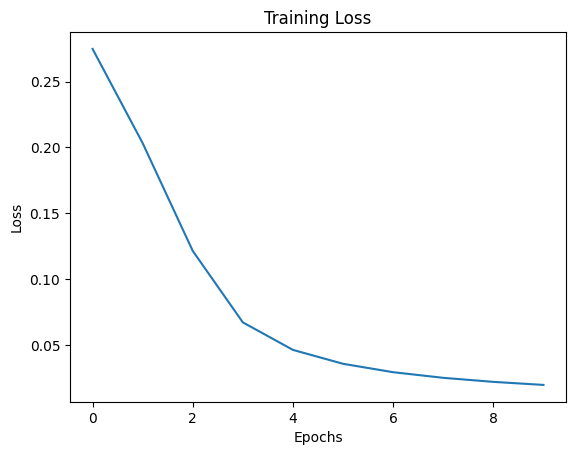

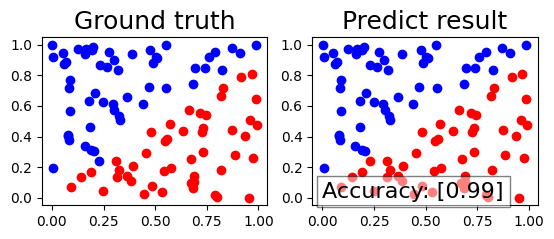

In [2]:
x, y = generate_linear()

# data reshape

input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 100
learning_rate = 0.1

model = NeuralNetwork()
# logging.debug("X shape: %s", x.shape)
model.add_layer(Conv_Layer(3, 1,1, activation_function="sigmoid"))
model.add_layer(FlattenLayer())
model.add_layer(Layer(input_size, output_size, activation_function="sigmoid"))
# model.add_layer(Layer(hidden_size1, hidden_size2, activation_function="sigmoid"))
# model.add_layer(Layer(hidden_size2, output_size, activation_function="sigmoid"))

model.train(x, y, epochs, learning_rate)
model.show_result(x, y)

Epoch 0| Loss: 0.25555061609401714 | Accuracy: [0.47619048]
Epoch 10| Loss: 0.2545017471500281 | Accuracy: [0.52380952]
Epoch 20| Loss: 0.2545098067980962 | Accuracy: [0.52380952]
Epoch 30| Loss: 0.2545216856337617 | Accuracy: [0.52380952]
Epoch 40| Loss: 0.25453364674981876 | Accuracy: [0.52380952]
Epoch 50| Loss: 0.25454563177037864 | Accuracy: [0.52380952]
Epoch 60| Loss: 0.2545576361396214 | Accuracy: [0.52380952]
Epoch 70| Loss: 0.25456965562909395 | Accuracy: [0.52380952]
Epoch 80| Loss: 0.2545816854211409 | Accuracy: [0.52380952]
Epoch 90| Loss: 0.25459371998911856 | Accuracy: [0.52380952]
Accuracy: [0.52380952]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.47834558]
Iter 2 | Ground truth: [1] | Prediction: [0.47848436]
Iter 3 | Ground truth: [0] | Prediction: [0.47855714]
Iter 4 | Ground truth: [1] | Prediction: [0.47866137]
Iter 5 | Ground truth: [0] | Prediction: [0.47876779]
Iter 6 | Ground truth: [1] | Prediction: [0.47884054]
Iter 7 | Ground truth: [0] | Predic

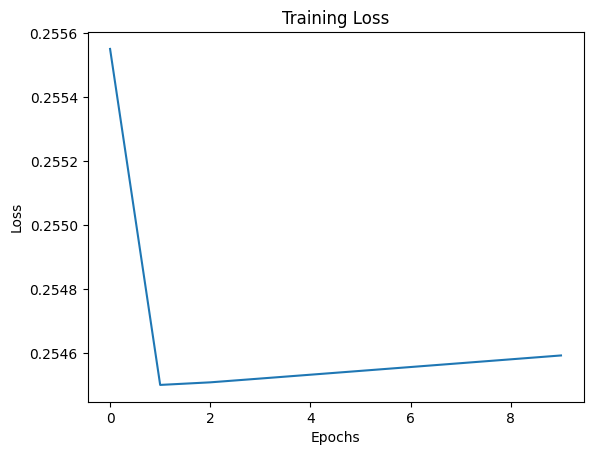

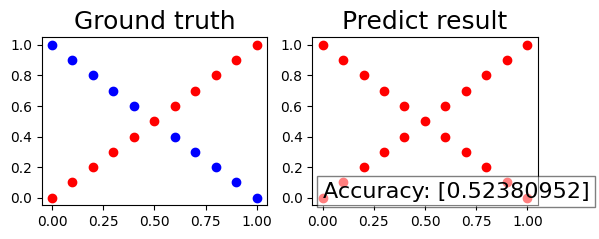

In [5]:
x, y = generate_XOR_easy()

input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 100
learning_rate = 0.1

model = NeuralNetwork()
# logging.debug("X shape: %s", x.shape)
model.add_layer(Conv_Layer(3, 1,1, activation_function="sigmoid"))
model.add_layer(FlattenLayer())
model.add_layer(Layer(input_size, output_size, activation_function="sigmoid"))

model.train(x, y, epochs, learning_rate)
model.show_result(x, y)